# Part 3: Exploring Statistical Models 


In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
sb.set() # set the default Seaborn style for graphics

In [2]:
movieData = pd.read_csv('cleaned-movie-dataset.csv')

### 1. Random Forest Regression

We want to predict the score of a movie using this statistical model by leveraging relevant predictors such that our model can learn from historical data to forecast the score of new movies.

Firstly, one-hot encoding is carried out to convert categorical variables into a numerical format that can be provided to ML algorithms. In this code, the categorical variables 'country', 'genre', and 'rating' are being one-hot encoded using the get_dummies() function.

In [3]:
encoded_data = pd.get_dummies(movieData, columns=['country', 'genre', 'rating'])

# Display the first few rows of the encoded DataFrame
print(encoded_data.head())

         gross  runtime      budget      votes  score  country_Argentina  \
0   46998772.0    146.0  19000000.0   927000.0    8.4                  0   
1   58853106.0    104.0   4500000.0    65000.0    5.8                  0   
2  538375067.0    124.0  18000000.0  1200000.0    8.7                  0   
3   83453539.0     88.0   3500000.0   221000.0    7.7                  0   
4   39846344.0     98.0   6000000.0   108000.0    7.3                  0   

   country_Aruba  country_Australia  country_Austria  country_Belgium  ...  \
0              0                  0                0                0  ...   
1              0                  0                0                0  ...   
2              0                  0                0                0  ...   
3              0                  0                0                0  ...   
4              0                  0                0                0  ...   

   rating_Approved  rating_G  rating_NC-17  rating_Not Rated  rating_PG  \

In [4]:
# separate the features used for prediction from the target variable. 
X = encoded_data.drop(columns=['score'])

# Target variable
y = encoded_data['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

# Train the Random Forest model
rf_model = RandomForestRegressor()

rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

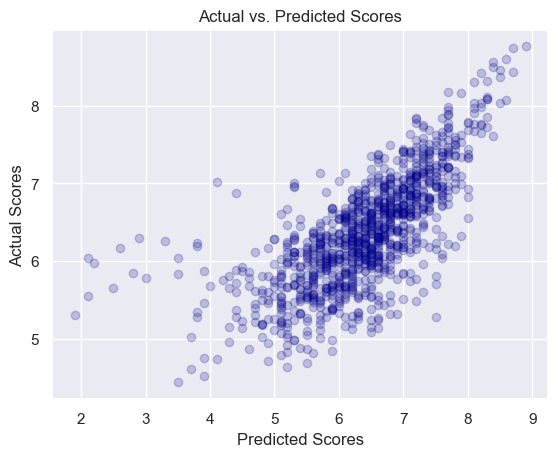

Train R^2 score: 0.9334852998704306
Test R^2 score: 0.5099256890084969
MAE: 0.4811852534562212
MSE: 0.46154959447004607
RMSE: 0.679374414053139


In [5]:
# Predict using the scaled features
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)


# Plot actual vs. predicted scores
plt.scatter(y_test, y_test_pred, alpha=0.2, color="DarkBlue")
plt.title('Actual vs. Predicted Scores')
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.show()

# Evaluate the R^2 values of each set
train_r2 = rf_model.score(X_train_scaled, y_train)
test_r2 = rf_model.score(X_test_scaled, y_test)
print(f'Train R^2 score: {train_r2}')
print(f'Test R^2 score: {test_r2}')

# Evaluate the model
print("MAE:", mean_absolute_error(y_test, rf_model.predict(X_test_scaled)))
print("MSE:", mean_squared_error(y_test, rf_model.predict(X_test_scaled)))
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_model.predict(X_test_scaled))))

While the training R^2 score indicates that the model fits the training data extremely well (0.93), the lower testing R^2 score (0.51) suggests that the model's performance on unseen data is not as good. Additionally, MSE is low at 0.46, indicating that the model's predictions are quite accurate on average.

One potential reason for the discrepancy between the training and testing scores could be outliers in the dataset which might be distorting the model's learning process.

#### Removal of Outliers

In [6]:
# Define a function to remove outliers
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Identify lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    # Remove outliers from the dataset
    clean_data = data.drop(outliers.index)
    
    return clean_data, outliers

# Columns for which outliers will be removed
columns_to_check = ['gross', 'runtime', 'budget', 'votes']

# Dictionary to store outliers
outliers_dict = {}

# Remove outliers for each column
for column in columns_to_check:
    clean_movieData, outliers = remove_outliers(movieData, column)
    outliers_dict[column] = outliers

# Print cleaned dataset
print(clean_movieData)

# Print the number of outliers removed for each column
for column, outliers in outliers_dict.items():
    print("Number of outliers removed for", column, ":", outliers.shape[0])


            gross  runtime       budget     votes        country      genre  \
1      58853106.0    104.0    4500000.0   65000.0  United States  Adventure   
3      83453539.0     88.0    3500000.0  221000.0  United States     Comedy   
4      39846344.0     98.0    6000000.0  108000.0  United States     Comedy   
5      39754601.0     95.0     550000.0  123000.0  United States     Horror   
6     115229890.0    133.0   27000000.0  188000.0  United States     Action   
...           ...      ...          ...       ...            ...        ...   
5418  426505244.0    124.0   90000000.0  140000.0  United States     Action   
5419  319715683.0     99.0   85000000.0  102000.0  United States     Action   
5420  245487753.0    101.0  175000000.0   53000.0  United States  Adventure   
5421  111105497.0    100.0  135000000.0   42000.0         Canada  Adventure   
5422  461421559.0    149.0   80000000.0    3700.0          China     Action   

         rating  score  
1             R    5.8  
3

In [7]:
encoded_data1 = pd.get_dummies(clean_movieData, columns=['country', 'genre', 'rating'])

# One-hot encode the categorical variables
X = encoded_data1.drop(columns=['score'])

# Target variable
y = encoded_data1['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

# Train the Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

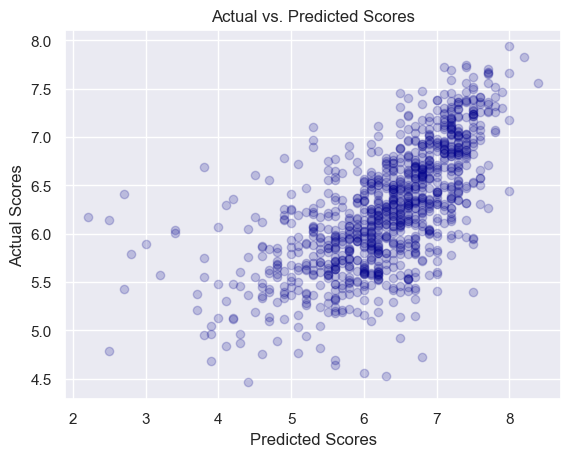

Train R^2 score: 0.9209250376655306
Test R^2 score: 0.41708126827508774
MAE: 0.5012423625254582
MSE: 0.4840874867617108
RMSE: 0.6957639590850555


In [8]:
# Predict using the scaled features
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)


# Plot actual vs. predicted scores
plt.scatter(y_test, y_test_pred, alpha=0.2, color="DarkBlue")
plt.title('Actual vs. Predicted Scores')
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.show()

# Evaluate the R^2 values of each set
train_r2 = rf_model.score(X_train_scaled, y_train)
test_r2 = rf_model.score(X_test_scaled, y_test)
print(f'Train R^2 score: {train_r2}')
print(f'Test R^2 score: {test_r2}')

# Evaluate the model
print("MAE:", mean_absolute_error(y_test, rf_model.predict(X_test_scaled)))
print("MSE:", mean_squared_error(y_test, rf_model.predict(X_test_scaled)))
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_model.predict(X_test_scaled))))

Removing outliers did not help significantly in reducing the discrepancy. As seen above, the discrepancy between the training and testing R^2 scores still remains.

This indicates a potential issue with overfitting. A high training R^2 score (e.g., 0.92) suggests that the model fits the training data very well. However, the relatively lower testing R^2 score (e.g., 0.42) indicates that the model's performance on unseen data is not as good. 

Additionally, the MSE score has increased slightly from the previous model, indicating decreased accuracy.

Hence we will carry out hyperparameter tuning to find the best configuration that helps the model generalize better to unseen data, thereby reducing the discrepancy between training and testing performance.

#### Hyper Parameter Tuning

By defining the hyperparameter grid below, we can search through different combinations of these parameters to find the optimal configuration for our random forest regression model.

In [9]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [4, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],      # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 14]    # Minimum number of samples required to be at a leaf node
}

In [10]:
# Initialize RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)

In [11]:
# Initialize GridSearchCV with the RandomForestRegressor and the hyperparameter grid
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

In [12]:
# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4, 14],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [4, 100, 200, 300]},
             scoring='r2')

In [13]:
# Get the best hyperparameters
best_params = grid_search.best_params_
# Train a new RandomForestRegressor model using the best hyperparameters
best_rf_regressor = RandomForestRegressor(**best_params, random_state=42)
best_rf_regressor.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=10, n_estimators=300,
                      random_state=42)

This process aims to optimize the model's performance by selecting the hyperparameters that yield the best results on the training data. In this case it is when max_depth=20, min_samples_split=10, n_estimators=300,random_state=42

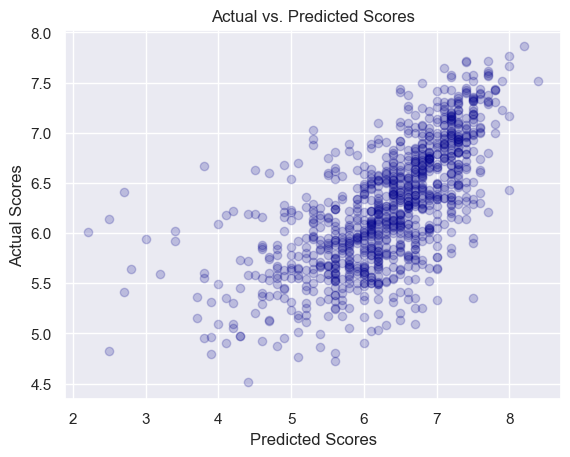

Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Train R^2 score: 0.806620629881791
Test R^2 score: 0.43208534650890296
MAE: 0.495257285406485
MSE: 0.4716272824003053
RMSE: 0.6867512522014833


In [14]:
# Predict using the scaled features
y_train_pred = best_rf_regressor.predict(X_train_scaled)
y_test_pred = best_rf_regressor.predict(X_test_scaled)


# Plot actual vs. predicted scores
plt.scatter(y_test, y_test_pred, alpha=0.2, color="DarkBlue")
plt.title('Actual vs. Predicted Scores')
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.show()

# Evaluate the model on training and test data
train_r2 = best_rf_regressor.score(X_train_scaled, y_train)
test_r2 = best_rf_regressor.score(X_test_scaled, y_test)

print("Best hyperparameters:", best_params)
print("Train R^2 score:", train_r2)
print("Test R^2 score:", test_r2)

# Evaluate the model
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("MSE:", mean_squared_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

After carrying out hyper parameter tuning, the discrepency between the R^2 score on the training and testing data has reduced(0.81 vs 0.43). This suggests better generalization capability, indicating that it may perform more reliably on unseen data compared to our previous model. 

However, the accuracy for the train set has decreased and the relatively low R^2 scores on this tuned model, alongside the comparable mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE) values in both sets, suggest that this Random Forest Regression model does not sufficiently capture the underlying patterns in the data.

Thus, while this latest model has slightly reduced the problem of overfitting, it still falls short of delivering satisfactory predictive performance, perhaps due to the complexity of the model. Further exploration of alternative modeling approaches may be necessary to achieve better predictive accuracy, such as Logistic Regression.